# MNIST Dataset Image Classification

In [3]:
import torch
import torchvision

from torchvision import datasets, transforms

In [10]:
# check for CUDA enabled GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
# load trian and test datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307, ), std=(0.3081, ))
])

trainset = datasets.MNIST('../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

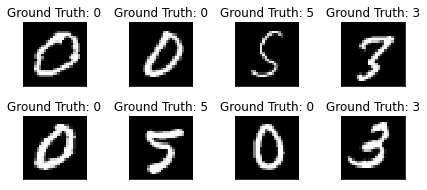

In [13]:
import numpy as np
import matplotlib.pyplot as plt
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show some images with their labels
fig = plt.figure()

for i in range(8):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# define network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [16]:
import torch.optim as optim

# instantiate a net
net = Net().to(device)
# use SGD optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [17]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [18]:
for epoch in range(10):
    train(net, device, trainloader, optimizer, epoch)
    test(net, device, testloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309969
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.674141
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.411174
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.407744
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.451149

Test set: Average loss: 0.2087, Accuracy: 9413/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.335322
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.187662
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.148527
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.230304
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.239112

Test set: Average loss: 0.1367, Accuracy: 9580/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.214320
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.266972
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.331690
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.326023
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.165985

Test set: Average loss: 0.1044, Accuracy: 9679/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.178234
Train Epoch: 3 [12800/60000 (21%)]	Lo

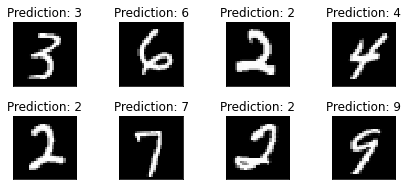

In [19]:
# get some random test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    output = net(images)

# viusalize some predictions on the test set
fig = plt.figure()

for i in range(8):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(images.cpu()[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

In [20]:
torch.save(net.state_dict(), "../models/mnist_notebook.pt")